# Grid search results analysis

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from itertools import combinations
import math
from glob import glob

FONTSIZE=14

In [2]:
data_df = pd.read_pickle('data/grid_search/grid_search.pkl')
data_df['dtype'].astype('str')
data_df.head()

,features,bond_dim,batch_size,initialize,dtype,loss,train_acc,test_acc,train_acc0,test_acc0,time
0,4,2,16,True,torch.float64,0.001245,1.0000,1.0,0.6684,0.664,200.066460
1,4,2,16,False,torch.float64,0.002246,0.9997,1.0,0.3502,0.338,194.302091
2,4,2,32,True,torch.float64,0.001204,1.0000,1.0,0.6655,0.673,131.457987
3,4,2,32,False,torch.float64,0.001216,1.0000,1.0,0.3023,0.305,126.006699
4,4,2,128,True,torch.float64,0.001168,1.0000,1.0,0.5006,0.501,77.283521


In [3]:
# divide float and complex
float_df = data_df[data_df['dtype'] == 'torch.float64'].drop(columns=['dtype'])
complex_df = data_df[data_df['dtype'] == 'torch.complex128'].drop(columns=['dtype'])

float_df.head()

,features,bond_dim,batch_size,initialize,loss,train_acc,test_acc,train_acc0,test_acc0,time
0,4,2,16,True,0.001245,1.0000,1.0,0.6684,0.664,200.066460
1,4,2,16,False,0.002246,0.9997,1.0,0.3502,0.338,194.302091
2,4,2,32,True,0.001204,1.0000,1.0,0.6655,0.673,131.457987
3,4,2,32,False,0.001216,1.0000,1.0,0.3023,0.305,126.006699
4,4,2,128,True,0.001168,1.0000,1.0,0.5006,0.501,77.283521


## float vs complex

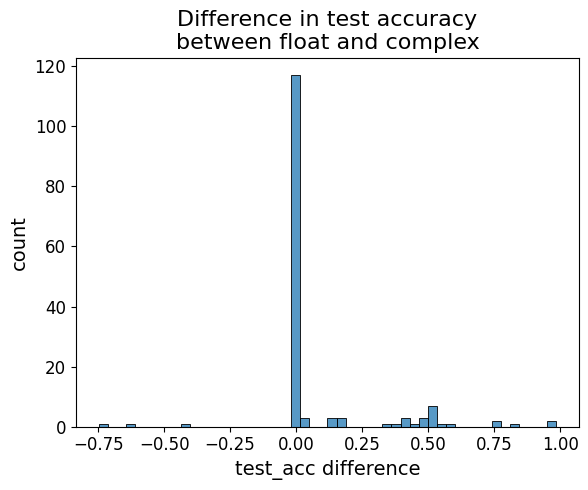

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.histplot(float_df.set_index(['features', 'bond_dim', 'batch_size', 'initialize'])['test_acc'] - complex_df.set_index(['features', 'bond_dim', 'batch_size', 'initialize'])['test_acc'], bins=50, ax=ax)
ax.set_title('Difference in test accuracy\nbetween float and complex', fontsize=FONTSIZE+2)
ax.set_xlabel('test_acc difference', fontsize=FONTSIZE)
ax.set_ylabel('count', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()

fig.savefig('data/grid_search/float_complex_diff.png', dpi=600)

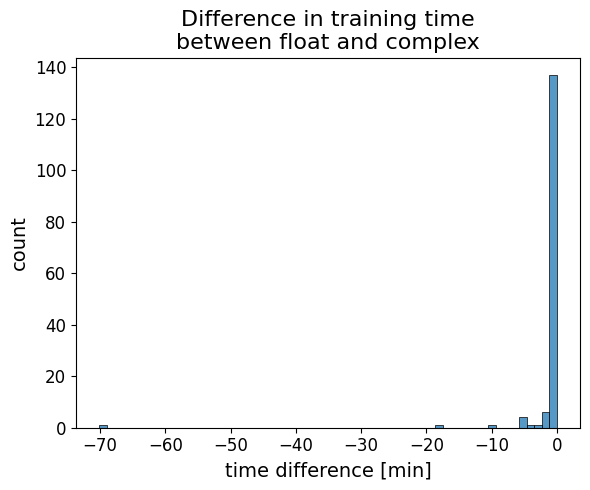

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.histplot((float_df.set_index(['features', 'bond_dim', 'batch_size', 'initialize'])['time'] - complex_df.set_index(['features', 'bond_dim', 'batch_size', 'initialize'])['time']) / 60., bins=60, ax=ax)
ax.set_title('Difference in training time\nbetween float and complex', fontsize=FONTSIZE+2)
ax.set_xlabel('time difference [min]', fontsize=FONTSIZE)
ax.set_ylabel('count', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()

fig.savefig('data/grid_search/float_complex_timediff.png', dpi=600)

## Initialization

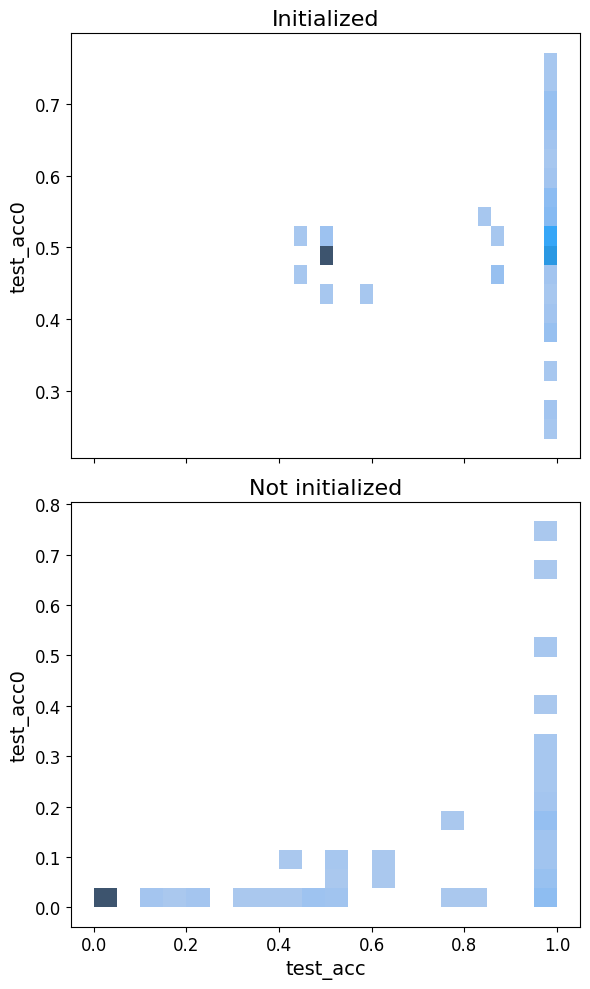

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), sharex=True)
df_initTrue = data_df[data_df['initialize'] == True].copy()
df_initFalse = data_df[data_df['initialize'] == False].copy()
df_initTrue['diff'] = df_initTrue['test_acc'] - df_initTrue['test_acc0']
df_initFalse['diff'] = df_initFalse['test_acc'] - df_initFalse['test_acc0']
sns.histplot(df_initTrue[['test_acc', 'test_acc0']], x = 'test_acc', y='test_acc0', bins=20, ax=ax[0])
sns.histplot(df_initFalse[['test_acc','test_acc0']], x = 'test_acc', y='test_acc0', bins=20, ax=ax[1])
ax[0].set_title('Initialized', fontsize=FONTSIZE+2)
ax[1].set_title('Not initialized', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[1].set_xlabel(ax[1].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[1].set_ylabel(ax[1].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
ax[1].tick_params(labelsize=FONTSIZE-2)

#fig.suptitle('Difference in test accuracy\nafter and before training', fontsize=FONTSIZE+2)
fig.tight_layout()

fig.savefig('data/grid_search/init_diff.png', dpi=600)

## confusion matrices

In [8]:
def heat_pairplot(df, variables, value='train_acc', fmt='.3f'):
    # get all combinations of variables
    pairs = list(combinations(variables, 2))

    rows = math.floor(len(pairs)**0.5)
    cols = math.ceil(len(pairs)/rows)
    fig, ax = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))
    if len(pairs) == 1:
        ax = np.array([ax])
    else:
        ax = ax.flatten()

    # plot
    for i, combo in enumerate(pairs):
        sns.heatmap(df.pivot_table(index=combo[0], columns=combo[1], values=value, aggfunc='mean'), ax=ax[i], annot=True, fmt=fmt, cmap='Blues')
        ax[i].set_title(f'{combo[0]} vs {combo[1]}')
        ax[i].set_xlabel(combo[1])
        ax[i].set_ylabel(combo[0])

    return fig, ax

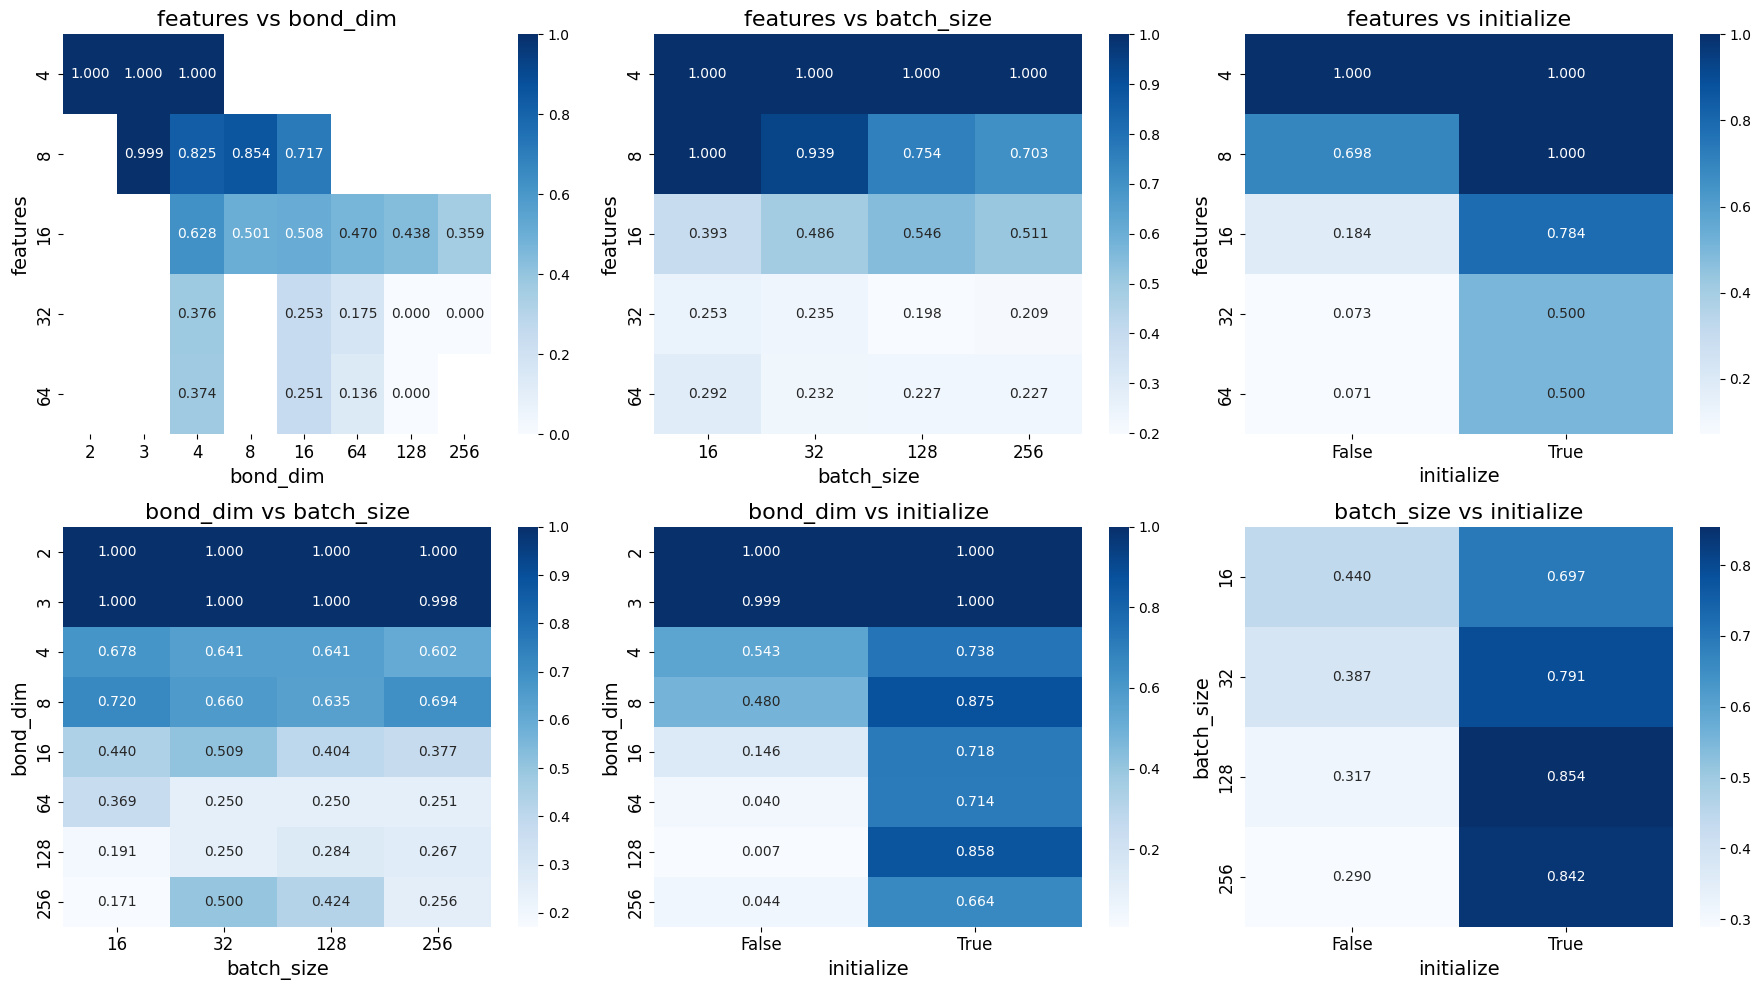

In [24]:
# plot heatmaps

fig, ax = heat_pairplot(data_df, data_df.columns[:4], 'test_acc')
for a in ax:
    a.tick_params(labelsize=FONTSIZE-2)
    a.set_title(a.get_title(), fontsize=FONTSIZE+2)
    a.set_xlabel(a.get_xlabel(), fontsize=FONTSIZE)
    a.set_ylabel(a.get_ylabel(), fontsize=FONTSIZE)

fig.tight_layout()

fig.savefig('data/grid_search/heatmaps.png', dpi=600)

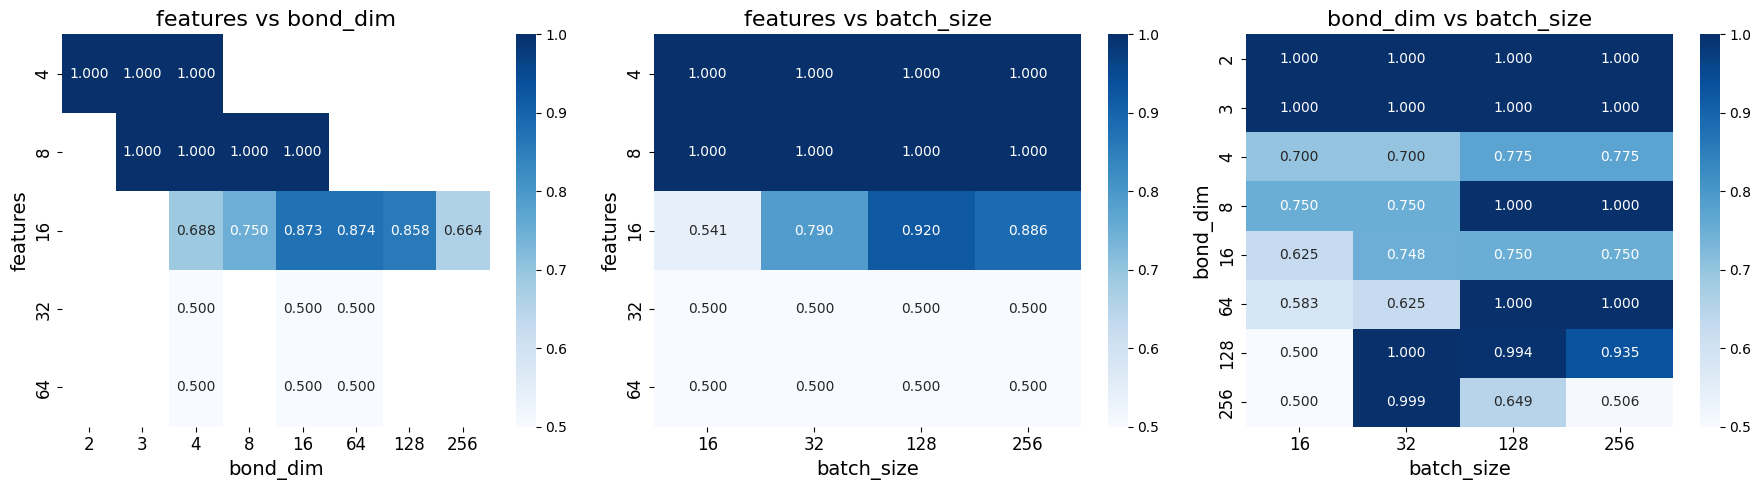

In [25]:

fig, ax = heat_pairplot(df_initTrue, df_initTrue.columns[:3], 'test_acc')
for a in ax:
    a.tick_params(labelsize=FONTSIZE-2)
    a.set_title(a.get_title(), fontsize=FONTSIZE+2)
    a.set_xlabel(a.get_xlabel(), fontsize=FONTSIZE)
    a.set_ylabel(a.get_ylabel(), fontsize=FONTSIZE)

fig.tight_layout()

fig.savefig('data/grid_search/heatmaps_initTrue.png', dpi=600)

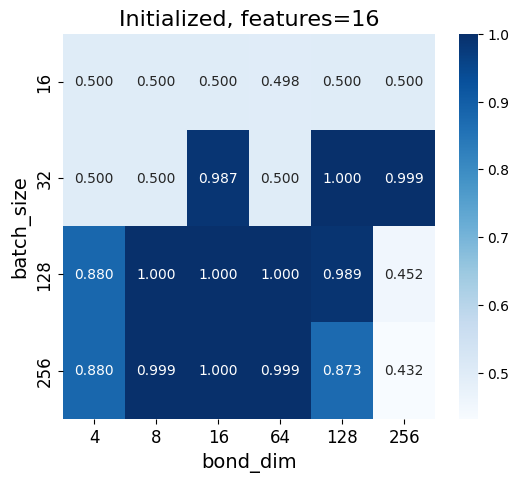

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

sns.heatmap(df_initTrue[(df_initTrue['features']==16) & (df_initTrue['dtype']=='torch.complex128')].pivot_table(index='batch_size', columns='bond_dim', values='test_acc', aggfunc='mean'), annot=True, fmt='.3f', cmap='Blues', ax=ax)
ax.set_title('Initialized, features=16', fontsize=FONTSIZE+2)
ax.set_xlabel('bond_dim', fontsize=FONTSIZE)
ax.set_ylabel('batch_size', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)

fig.savefig('data/grid_search/heatmap_initTrue_features16.png', dpi=600)

<Axes: xlabel='test_acc0', ylabel='Count'>

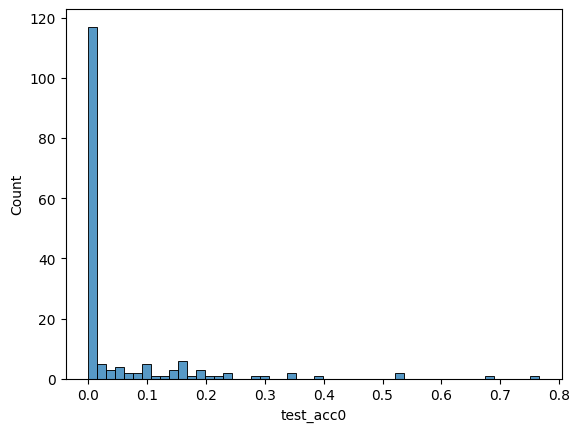

In [30]:
sns.histplot(df_initFalse['test_acc0'], bins=50)

## Dynamic range

In [3]:
root_dir = 'data/grid_search/'
file_list = glob('model_*True_torch.float64*.pth', root_dir=root_dir)
print(len(file_list))

72


In [4]:
import re

feat_bd_tofile_dict = {}
for file in file_list:
    feat = int(re.findall(r'\d+', file.split('_')[1])[0])
    bd = int(re.findall(r'\d+', file.split('_')[2])[0])
    if feat not in feat_bd_tofile_dict:
        feat_bd_tofile_dict[feat] = {}
    feat_bd_tofile_dict[feat][bd] = [file] + feat_bd_tofile_dict[feat].get(bd, [])

In [5]:
features = list(feat_bd_tofile_dict.keys())
features.sort()
bds = []
for feat in features:
    bds += list(feat_bd_tofile_dict[feat].keys())
bds = np.unique(bds).tolist()

df = pd.DataFrame(index=pd.MultiIndex.from_product([features, bds], names=['feat', 'bd']), columns=['abs_min', 'abs_max', 'mean_min', 'mean_max', 'std_min', 'std_max', 'n'], dtype=float)

for feat in features:
    for bd in bds:
        if bd in feat_bd_tofile_dict[feat]:
            abs_tensors = np.stack([np.concatenate([np.abs(x.cpu().numpy().flatten()) for x in torch.load(root_dir + file).values()]) for file in feat_bd_tofile_dict[feat][bd]], axis=0)
            df.loc[feat, bd] = [np.min(abs_tensors), np.max(abs_tensors), np.mean(abs_tensors.min(-1)), np.mean(abs_tensors.max(-1)), 
                                np.std(abs_tensors.min(-1)), np.std(abs_tensors.max(-1)), abs_tensors.shape[0]]
        else:
            df.loc[feat, bd] = [None, None, None, None, None, None, 0]


In [6]:
df

abs_min        abs_max       mean_min       mean_max  \
feat bd                                                                
4    2     1.874994e-05   1.081951e+00   7.923665e-04   1.051786e+00   
     3     2.301964e-05   1.043676e+00   4.042941e-04   1.033316e+00   
     4     1.374658e-13   1.040516e+00   6.282766e-05   1.031356e+00   
     8              NaN            NaN            NaN            NaN   
     16             NaN            NaN            NaN            NaN   
     64             NaN            NaN            NaN            NaN   
     128            NaN            NaN            NaN            NaN   
     256            NaN            NaN            NaN            NaN   
8    2              NaN            NaN            NaN            NaN   
     3     4.556414e-24   2.250832e+00   5.489433e-16   1.748507e+00   
     4     2.287051e-31   1.657604e+00   1.080575e-10   1.265075e+00   
     8     3.651072e-21   1.033941e+00   4.749731e-11   1.006641e+00   
     16    3.591164e-29   1.027693e+00   3.211627e-09   1.006382e+00   
     64             NaN            NaN            NaN            NaN   
     128            NaN            NaN            NaN            NaN   
     256            NaN            NaN            NaN            NaN   
16   2              NaN            NaN            NaN            NaN   
     3              NaN            NaN            NaN            NaN   
     4    4.315406e-300   1.118861e+00   4.294731e-17   5.560836e-01   
     8    3.970787e-300   1.126914e+00   9.179876e-23   5.568325e-01   
     16   1.482197e-323   1.742583e+00   1.184514e-12   9.759239e-01   
     64    3.901629e-16   1.827840e+00   9.907655e-08   1.442869e+00   
     128  5.928788e-323   1.426093e+00   2.566035e-07   9.544622e-01   
     256  1.083528e-219   1.727028e+00   1.803445e-07   1.239140e+00   
32   2              NaN            NaN            NaN            NaN   
     3              NaN            NaN            NaN            NaN   
     4    1.177852e-299   1.352615e-70   7.247574e-79   3.381538e-71   
     8              NaN            NaN            NaN            NaN   
     16   3.963990e-301   9.203102e-66   4.022238e-81   2.300775e-66   
     64   3.590120e-302  3.031710e-147  1.535430e-251  1.515855e-147   
     128            NaN            NaN            NaN            NaN   
     256            NaN            NaN            NaN            NaN   
64   2              NaN            NaN            NaN            NaN   
     3              NaN            NaN            NaN            NaN   
     4    2.225667e-319   2.597291e-65   4.269259e-79   6.493228e-66   
     8              NaN            NaN            NaN            NaN   
     16   2.224629e-319   1.400692e-70   1.419399e-80   3.501731e-71   
     64   3.119036e-320  1.926918e-119  6.396992e-303  9.634588e-120   
     128            NaN            NaN            NaN            NaN   
     256            NaN            NaN            NaN            NaN   

               std_min        std_max    n  
feat bd                                     
4    2    6.759860e-04   1.758121e-02  4.0  
     3    5.935019e-04   1.059333e-02  4.0  
     4    6.306672e-05   1.466214e-02  4.0  
     8             NaN            NaN  0.0  
     16            NaN            NaN  0.0  
     64            NaN            NaN  0.0  
     128           NaN            NaN  0.0  
     256           NaN            NaN  0.0  
8    2             NaN            NaN  0.0  
     3    9.507908e-16   4.616685e-01  4.0  
     4    1.871455e-10   2.493898e-01  4.0  
     8    8.226752e-11   2.804158e-02  4.0  
     16   5.562702e-09   1.784118e-02  4.0  
     64            NaN            NaN  0.0  
     128           NaN            NaN  0.0  
     256           NaN            NaN  0.0  
16   2             NaN            NaN  0.0  
     3             NaN            NaN  0.0  
     4    7.438691e-17   5.561037e-01  4.0  
     8    1.589980e-22   5.569113e-01  4.0  
 

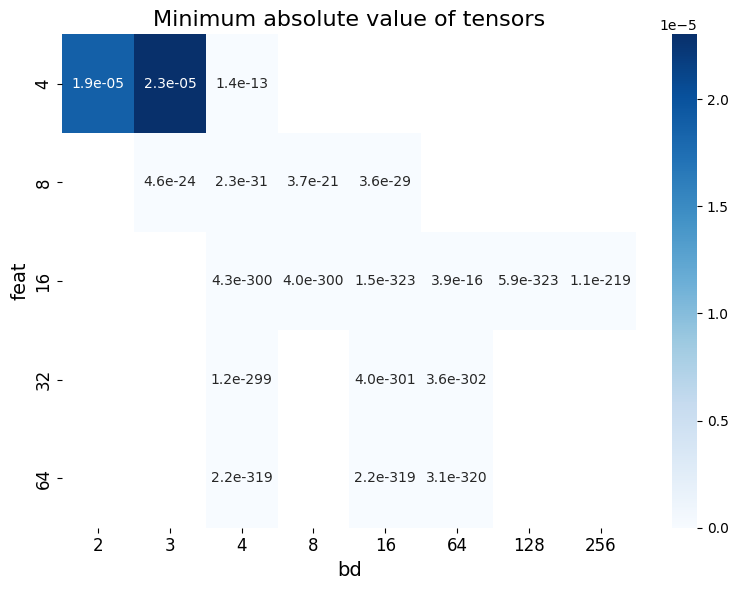

In [9]:
fig, ax = heat_pairplot(df, ['feat', 'bd'], 'abs_min', fmt='2.1e')
ax[0].set_title('Minimum absolute value of tensors', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()
fig.savefig('data/grid_search/heatmap_abs_min.png', dpi=600)

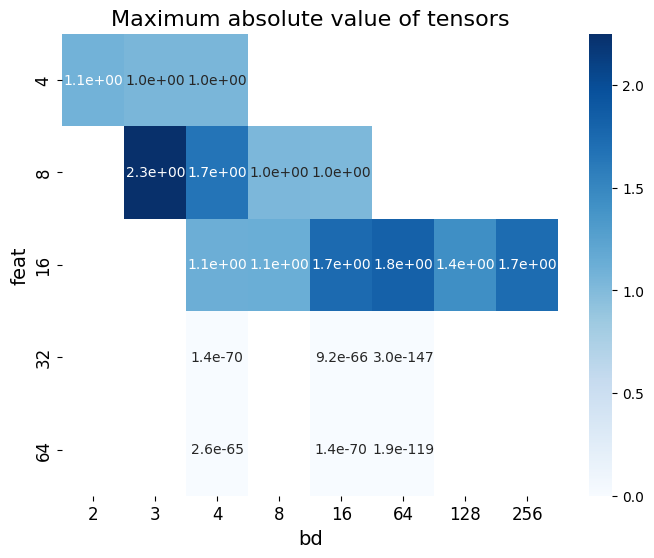

In [58]:
fog, ax = heat_pairplot(df, ['feat', 'bd'], 'abs_max', fmt='2.1e')
ax[0].set_title('Maximum absolute value of tensors', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()
fig.savefig('data/grid_search/heatmap_abs_max.png', dpi=600)

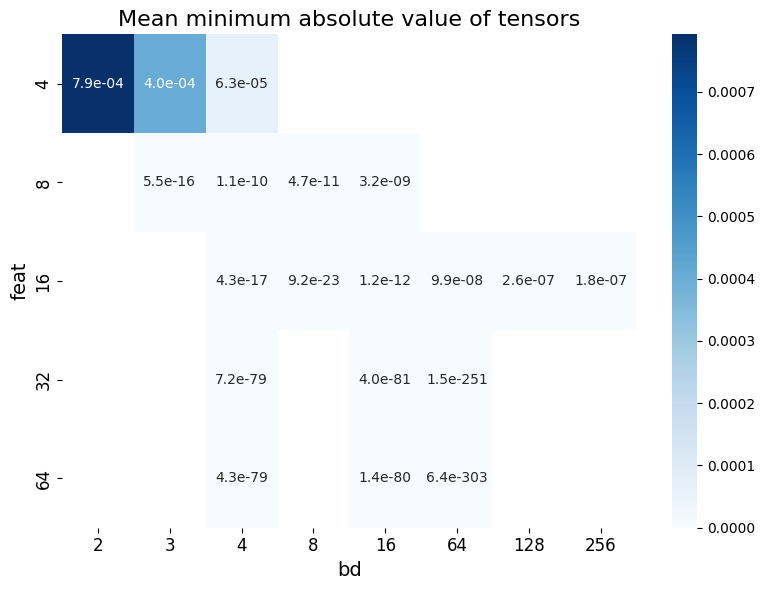

In [59]:
fig, ax = heat_pairplot(df, ['feat', 'bd'], 'mean_min', fmt='2.1e')
ax[0].set_title('Mean minimum absolute value of tensors', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()
fig.savefig('data/grid_search/heatmap_mean_min.png', dpi=600)

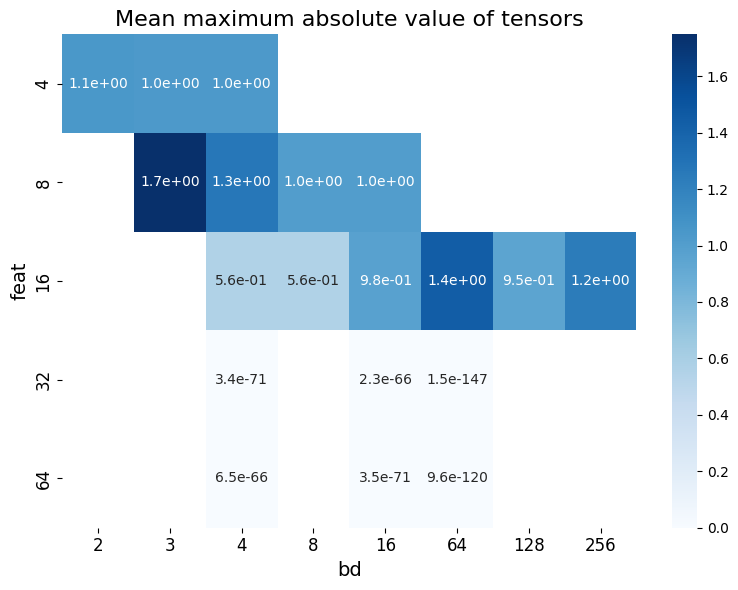

In [60]:
fig, ax = heat_pairplot(df, ['feat', 'bd'], 'mean_max', fmt='2.1e')
ax[0].set_title('Mean maximum absolute value of tensors', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()
fig.savefig('data/grid_search/heatmap_mean_max.png', dpi=600)

# Fixed precision analysis

In [2]:
df = pd.read_csv('data/grid_search_fp/grid_search.csv', index_col=0)
df = df.fillna(0)
df

,bond_dim,batch_size,quantize,wl,sample,loss,train_acc,test_acc,train_acc0,test_acc0,time
0,3,32,True,4.0,0,0.287157,0.5000,0.500,0.5,0.5,274.158018
1,3,32,True,4.0,1,0.288108,0.5000,0.500,0.5,0.5,280.553887
2,3,32,True,4.0,2,0.289864,0.5000,0.500,0.5,0.5,285.096199
3,3,32,True,4.0,3,0.287556,0.5000,0.500,0.5,0.5,277.835377
4,3,32,True,4.0,4,0.290801,0.5000,0.500,0.5,0.5,284.900186
...,...,...,...,...,...,...,...,...,...,...,...
155,16,256,False,0.0,0,0.009682,0.9990,0.997,0.5,0.5,84.591248
156,16,256,False,0.0,1,0.009780,0.9987,0.998,0.5,0.5,83.108593
157,16,256,False,0.0,2,0.009755,0.9991,0.998,0.5,0.5,82.971719
158,16,256,False,0.0,3,0.009710,0.9987,0.999,0.5,0.5,84.086871


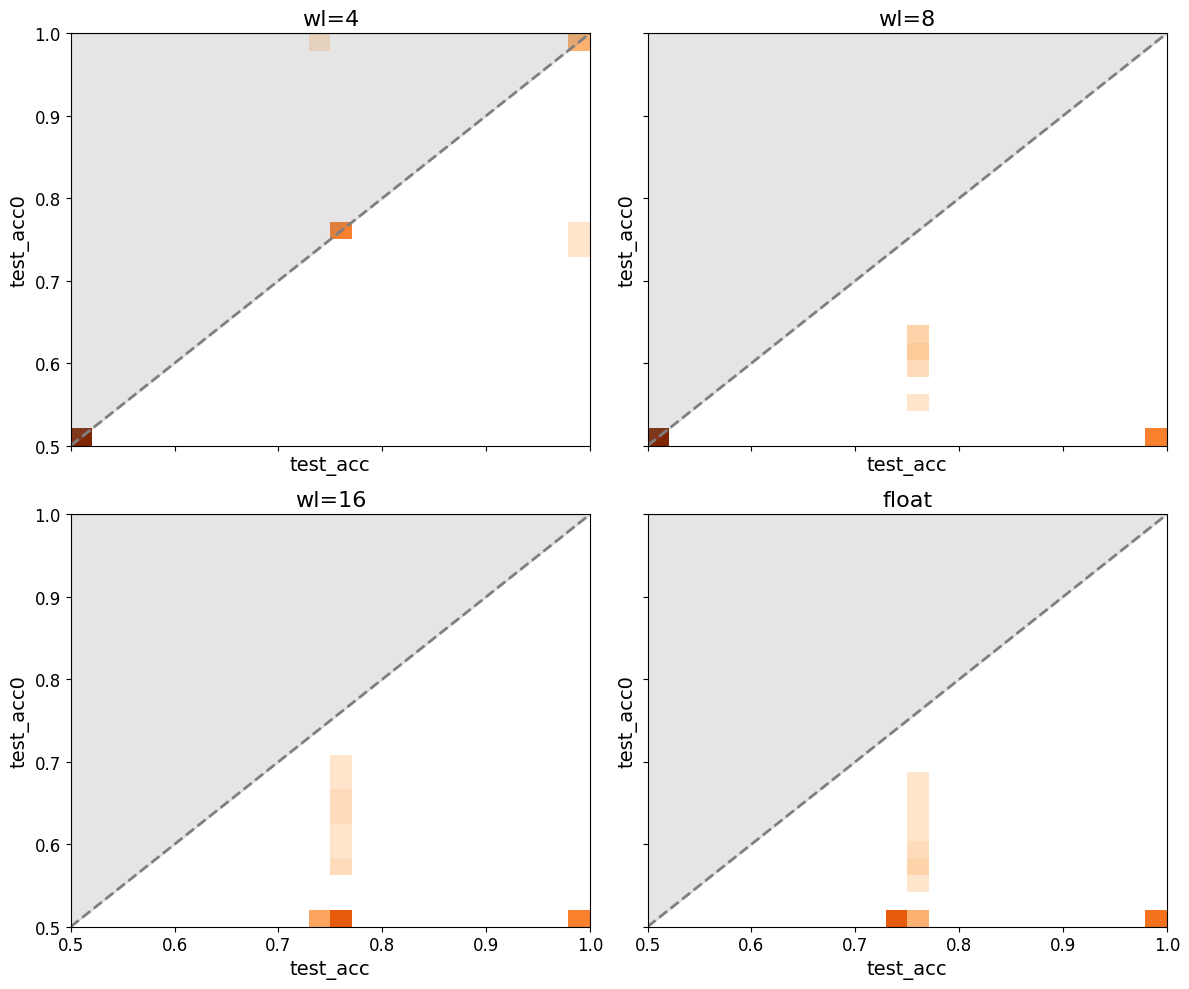

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axs = axs.flatten()
edges = np.linspace(0.5, 1.0, 25)

for i, wl in enumerate(df['wl'].unique()):
    axs[i].hist2d(df[df['wl'] == wl]['test_acc'], df[df['wl'] == wl]['test_acc0'], cmap='Oranges', bins=edges, cmin=0.1, vmin=-2, vmax=20)
    axs[i].plot([0.5, 1.0], [0.5, 1.0], color='tab:grey', linestyle='--', lw=2)
    axs[i].fill_between([0.5, 1.0], [0.5, 1.0], 1, color='tab:grey', alpha=0.2)
    axs[i].set_title(f'wl={int(wl)}' if wl > 0 else 'float', fontsize=FONTSIZE+2)
    axs[i].set_xlabel('test_acc', fontsize=FONTSIZE)
    axs[i].set_ylabel('test_acc0', fontsize=FONTSIZE)
    axs[i].tick_params(labelsize=FONTSIZE-2)

#_,_,_, im = axs[-1].hist2d(df[df['quantize']==False]['test_acc'], df[df['quantize']==False]['test_acc0'], bins=20, cmap='Blues')
#axs[-1].set_xlim(0.5, 1.0)
#axs[-1].set_ylim(0.5, 0.8)

fig.tight_layout()
fig.savefig('data/grid_search_fp/heatmaps.png', dpi=600)